## Домашняя работа 4.

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать:

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов:
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

In [29]:
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [3]:
data = pd.read_csv('data.adult.csv')

data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [4]:
data = data.astype(str)

data.replace('?', pd.NA, inplace=True)

missing_features = data.columns[data.isnull().any()].tolist()

data_cleaned = data.dropna()

print(f'Пропущенные признаки: {missing_features}')
print()
print(f'Размер очищенного датасета: {data_cleaned.shape}')

Пропущенные признаки: ['workclass', 'occupation']

Размер очищенного датасета: (15347, 14)


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [5]:
data['target'] = data['>50K,<=50K'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
data = data.drop(columns=['>50K,<=50K'])

for col in data.columns:
    if data[col].dtype == 'object':
        try:
            data[col] = pd.to_numeric(data[col])
        except ValueError:
            pass

numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
data_numeric = data[numeric_features].drop(columns=['target'])

In [6]:
target = data['target']

data = data.drop(columns=['target'])

print("Первые строки числовых данных:")
print(data_numeric.head())
print()
print("Первые строки целевой переменной:")
print(target.head())

Первые строки числовых данных:
   age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
0   34  284843              9           594             0              60
1   40  190290             10             0             0              40
2   36  177858             13             0             0              40
3   22  184756             10             0             0              30
4   47  149700             13         15024             0              40

Первые строки целевой переменной:
0    0
1    0
2    0
3    0
4    1
Name: target, dtype: int64


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)

Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

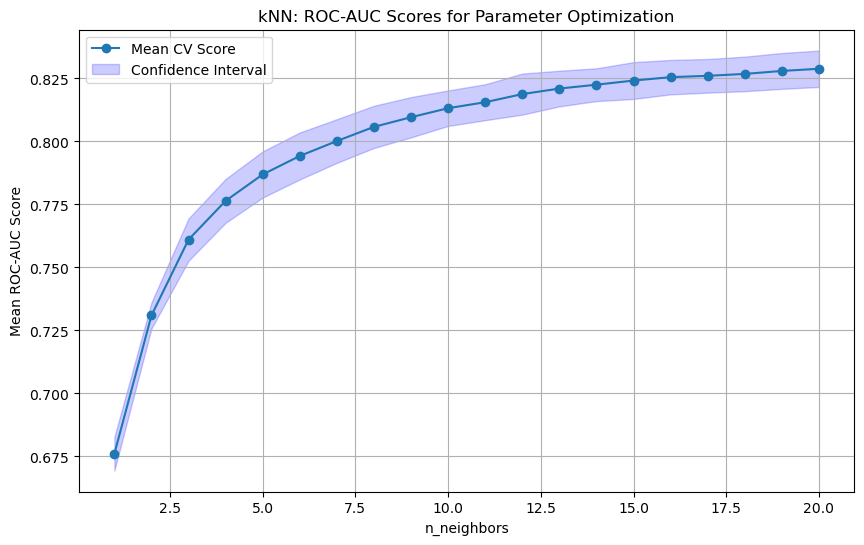

Наилучшие подобранные параметры для kNN: {'n_neighbors': 20}
Лучший ROC-AUC для kNN: 0.8288398510209296



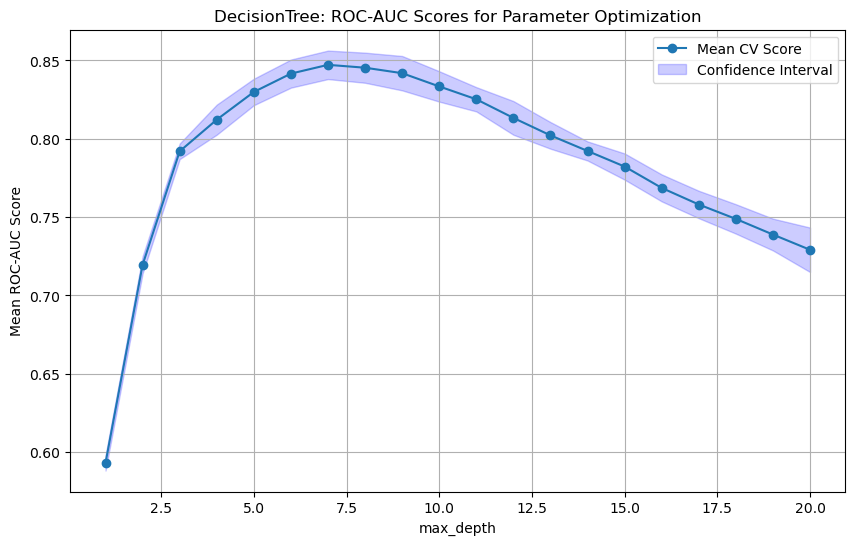

Наилучшие подобранные параметры для DecisionTree: {'max_depth': 7}
Лучший ROC-AUC для DecisionTree: 0.8471829610989795



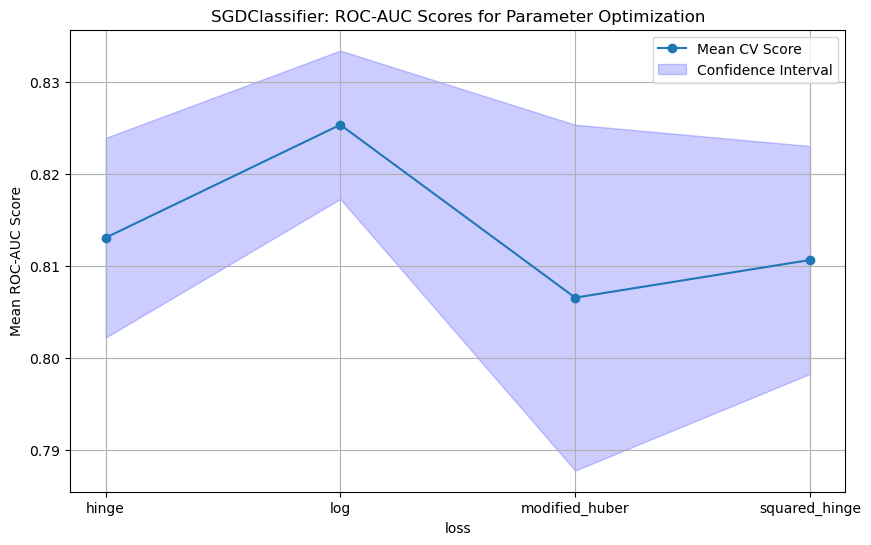

Наилучшие подобранные параметры для SGDClassifier: {'loss': 'log'}
Лучший ROC-AUC для SGDClassifier: 0.8253164626166978



In [11]:
X = data_numeric.values 
y = target.values      

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = {
    "kNN": {
        "model": KNeighborsClassifier(),
        "param_grid": {"n_neighbors": range(1, 21)}
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "param_grid": {"max_depth": range(1, 21)}
    },
    "SGDClassifier": {
        "model": SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
        "param_grid": {"loss": ['hinge', 'log', 'modified_huber', 'squared_hinge']}
    }
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def plot_cv_results(param_range, mean_scores, std_scores, title, xlabel):
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, mean_scores, marker='o', label='Mean CV Score')
    plt.fill_between(param_range, 
                     mean_scores - std_scores, 
                     mean_scores + std_scores, 
                     color='blue', alpha=0.2, label='Confidence Interval')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Mean ROC-AUC Score')
    plt.legend()
    plt.grid()
    plt.show()

for name, config in models.items():
    grid_search = GridSearchCV(
        estimator=config["model"],
        param_grid=config["param_grid"],
        cv=cv,
        scoring='roc_auc',
        return_train_score=False
    )
    grid_search.fit(X_scaled, y)
    
    results = grid_search.cv_results_
    param_range = list(config["param_grid"].values())[0] 
    mean_scores = results['mean_test_score']
    std_scores = results['std_test_score']
    
    plot_cv_results(param_range, mean_scores, std_scores, 
                    title=f'{name}: ROC-AUC Scores for Parameter Optimization', 
                    xlabel=list(config["param_grid"].keys())[0])
    
    print(f"Наилучшие подобранные параметры для {name}: {grid_search.best_params_}")
    print(f"Лучший ROC-AUC для {name}: {grid_search.best_score_}\n")

**Что вы можете сказать о получившихся графиках?**

***kNN:***

1. Качество модели (ROC-AUC Score) постепенно улучшается с увеличением числа соседей, достигая максимума при n_neighbors = 20;

2. Доверительный интервал с ростом числа соседей немного сужается.

***Decision Tree:***

1. Качество модели улучшается с увеличением глубины дерева (max_depth) до значения 7, после чего начинается снижение (это типичное поведение из-за переобучения: при слишком большой глубине модель начинает запоминать данные вместо их обобщения);

2. Глубина max_depth = 7 обеспечивает баланс между точностью и обобщающей способностью.

***SGDClassifier:***

1. Наилучшая функция потерь для модели - log, она показывает наибольшее среднее качество;

2. Относительно широкий ДИ может указывать на нестабильность модели при изменении типа функции потерь.

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

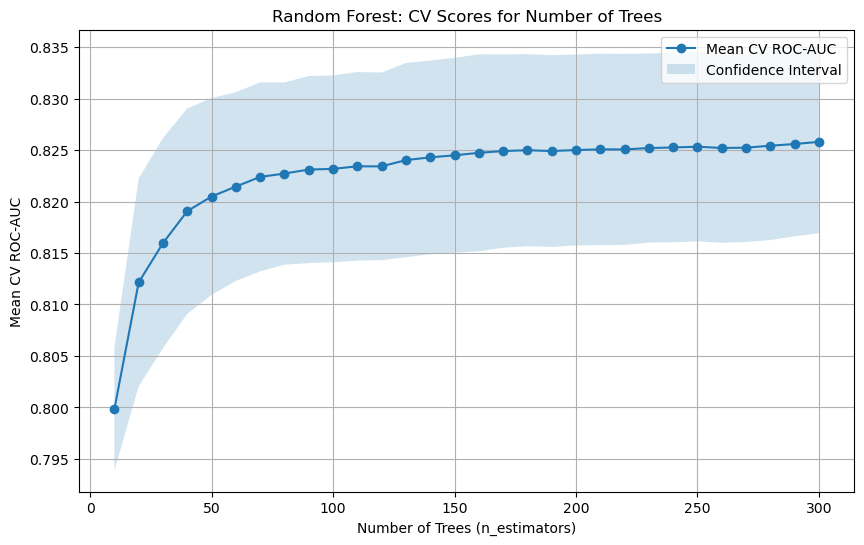

Оптимальное число деревьев: 60


In [9]:
# За максимально возможное число деревьев примем max_trees = 300:

max_trees = 300
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []
tree_counts = range(10, max_trees + 1, 10)

for n_trees in tree_counts:
    rf.set_params(n_estimators=n_trees)
    cv_score = cross_val_score(rf, X_scaled, y, cv=cv, scoring='roc_auc', n_jobs=-1)  # Изменение метрики на ROC-AUC
    scores.append((n_trees, cv_score.mean(), cv_score.std()))

scores = np.array(scores)

plt.figure(figsize=(10, 6))
plt.plot(scores[:, 0], scores[:, 1], marker='o', label='Mean CV ROC-AUC')
plt.fill_between(scores[:, 0], 
                 scores[:, 1] - scores[:, 2], 
                 scores[:, 1] + scores[:, 2], 
                 alpha=0.2, label='Confidence Interval')
plt.title('Random Forest: CV Scores for Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean CV ROC-AUC')
plt.legend()
plt.grid()
plt.show()

stabilized_trees = scores[:, 0][np.argmax(np.gradient(scores[:, 1]) < 0.001)]
print(f"Оптимальное число деревьев: {int(stabilized_trees)}")

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

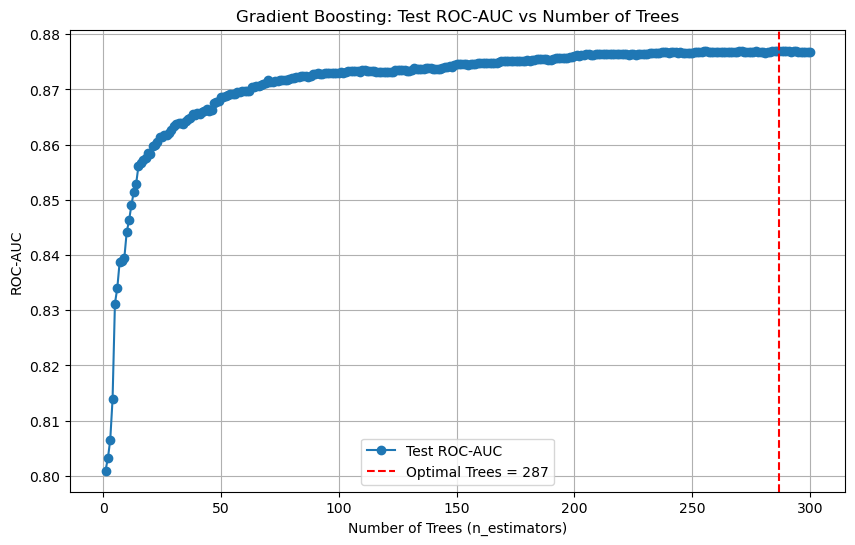

Оптимальное число деревьев для Gradient Boosting-алгоритма: 287


In [10]:
# За максимально возможное число деревьев также примем max_trees = 300:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

max_trees = 300

gbc = GradientBoostingClassifier(n_estimators=max_trees, random_state=42)
gbc.fit(X_train, y_train)

roc_auc_scores = []
for y_pred_proba in gbc.staged_predict_proba(X_test):
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    roc_auc_scores.append(roc_auc)

optimal_trees = np.argmax(roc_auc_scores) + 1

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_trees + 1), roc_auc_scores, label="Test ROC-AUC", marker="o")
plt.axvline(optimal_trees, color="red", linestyle="--", label=f"Optimal Trees = {optimal_trees}")
plt.title("Gradient Boosting: Test ROC-AUC vs Number of Trees")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("ROC-AUC")
plt.legend()
plt.grid()
plt.show()

print(f"Оптимальное число деревьев для Gradient Boosting-алгоритма: {optimal_trees}")

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масштабирование повлиять на работу этих алгоритмов?

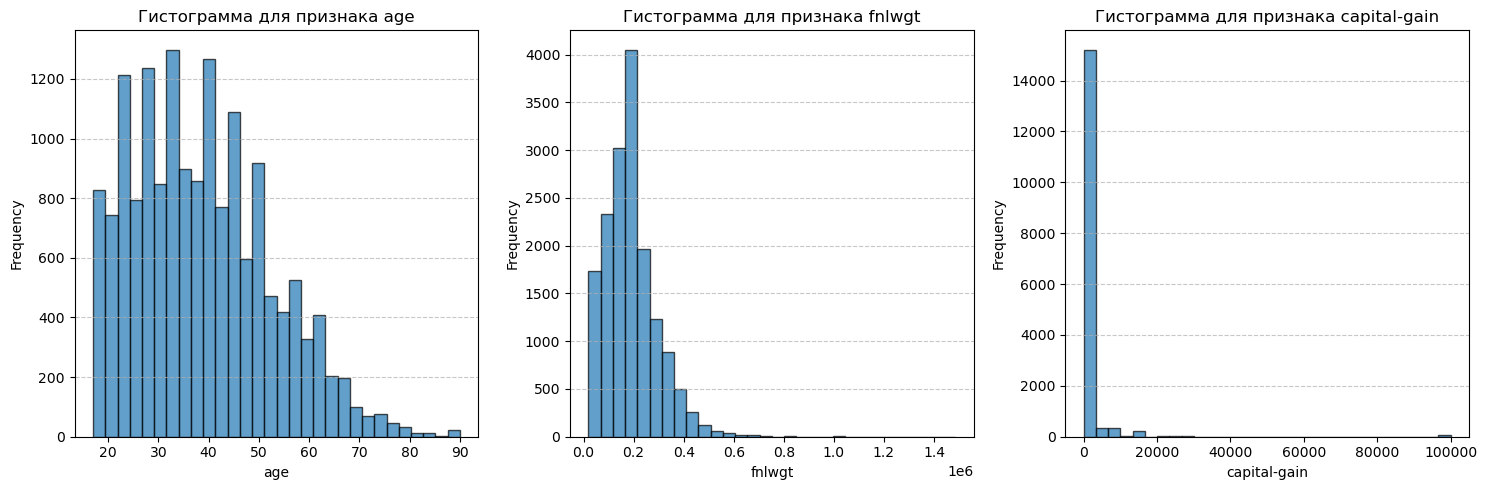

Анализ признаков:

age:
  Min: 17
  Max: 90
  Mean: 38.64
  Std Dev: 13.64

fnlwgt:
  Min: 19302
  Max: 1484705
  Mean: 189459.42
  Std Dev: 106664.40

capital-gain:
  Min: 0
  Max: 99999
  Mean: 1020.42
  Std Dev: 6862.04



In [36]:
features_to_plot = ['age', 'fnlwgt', 'capital-gain']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(1, 3, i)
    plt.hist(data_numeric[feature], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"Гистограмма для признака {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("Анализ признаков:")
print()
for feature in features_to_plot:
    print(f"{feature}:")
    print(f"  Min: {data_numeric[feature].min()}")
    print(f"  Max: {data_numeric[feature].max()}")
    print(f"  Mean: {data_numeric[feature].mean():.2f}")
    print(f"  Std Dev: {data_numeric[feature].std():.2f}")
    print()

**Анализ результатов получившихся графиков:**

***Особенности данных:***

*Возраст (Age):*

1. Распределение относительно равномерное с максимумом в диапазоне от 20 до 40 лет;

2. Признак находится в небольшом диапазоне значений (примерно от 0 до 80).

*Вес записи (fnlwgt):*

1. Распределение сильно скошено в сторону меньших значений;

2. Диапазон значений очень большой (от тысяч до миллионов).

*Капитальный прирост (capital-gain):*

1. Распределение имеет экстремальный перекос, где большая часть значений равна 0;

2. Присутствуют редкие большие значения, что создает значительный разброс.


***Влияние на алгоритмы:***

1. Чувствительные к масштабу алгоритмы (Линейные модели (например, SGDClassifier) и алгоритмы на основе расстояния (например, kNN)) - из-за большого разброса значений признаков (fnlwgt и capital-gain) эти алгоритмы могут придавать непропорционально большое значение этим признакам, что ухудшит качество;

2. Нечувствительные к масштабу алгоритмы (Деревья решений и ансамбли, основанные на деревьях (например, DecisionTree, RandomForest, GradientBoosting), не зависят от масштаба признаков, так как их разделяющие критерии основаны на порогах, а не на расстояниях).


***Влияние масштабирования:***

Масштабирование, такое как StandardScaler или MinMaxScaler, приводит признаки к одному диапазону (например, стандартному нормальному распределению), что помогает улучшить качество алгоритмов, зависящих от расстояния и градиентов (SGDClassifier, kNN) и практически не влияет на деревья решений и их ансамбли.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [23]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data_numeric)
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

models = {
    "kNN": {
        "model": KNeighborsClassifier(),
        "param_grid": {"n_neighbors": range(1, 21)}
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "param_grid": {"max_depth": range(1, 61)}
    },
    "SGDClassifier": {
        "model": SGDClassifier(random_state=42, max_iter=10000, tol=1e-3),
        "param_grid": {"loss": ['hinge', 'log', 'modified_huber', 'squared_hinge']}
    }
}

results = {}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, config in models.items():
    grid_search = GridSearchCV(
        config["model"],
        config["param_grid"],
        cv=cv,
        scoring='roc_auc',
        return_train_score=False
    )
    grid_search.fit(X_train, y_train)
    
    results[name] = {
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    print(f"Наилучшие параметры для {name}: {grid_search.best_params_}")
    print(f"Наилучший ROC-AUC для {name}: {grid_search.best_score_}\n")

Наилучшие параметры для kNN: {'n_neighbors': 20}
Наилучший ROC-AUC для kNN: 0.821891830647559

Наилучшие параметры для DecisionTree: {'max_depth': 7}
Наилучший ROC-AUC для DecisionTree: 0.8413187861620008

Наилучшие параметры для SGDClassifier: {'loss': 'modified_huber'}
Наилучший ROC-AUC для SGDClassifier: 0.8276168125746439



**Изменилось ли качество у некоторых алгоритмов?**

***Чувствительные к масштабу алгоритмы (kNN, SGDClassifier):***

Вообще, масштабирование значительно влияет на их работу, однако в текущей задаче качество осталось почти неизменным.


***Нечувствительные к масштабу алгоритмы (Decision Tree):***

В данном случае масштабирование практически никогда не влияет на качество.

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [22]:
# Действительно, перебор гиперпараметров в данном случае операция ресурсоемкая,
# поэтому сделаем это для каждой модели отдельно - начнем с KNN-алгоритма:

# Лучше будем использовать StandardScaler:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_numeric)
y = target.values

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'n_neighbors': range(1, 21),
    'metric': ['euclidean', 'manhattan'] 
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры для kNN:", grid_search.best_params_)
print("Лучшее качество (CV ROC-AUC):", grid_search.best_score_)

best_knn = grid_search.best_estimator_
test_proba = best_knn.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, test_proba)
print("ROC-AUC на тестовой выборке:", test_roc_auc)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Лучшие параметры для kNN: {'metric': 'manhattan', 'n_neighbors': 20}
Лучшее качество (CV ROC-AUC): 0.8312781790548126
ROC-AUC на тестовой выборке: 0.8398286633443688


In [24]:
# Теперь перейдем к DecisonTree:

param_grid = {
    'max_depth': range(1, 61),
    'criterion': ['gini', 'entropy']
}

decision_tree = DecisionTreeClassifier(random_state=42)

grid_search_tree = GridSearchCV(
    estimator=decision_tree,
    param_grid=param_grid,
    scoring='roc_auc',  
    cv=5,
    n_jobs=-1,
    verbose=1  
)

grid_search_tree.fit(X_train, y_train)

print("Лучшие параметры для Decision Tree:", grid_search_tree.best_params_)
print("Лучшее качество (CV ROC-AUC):", grid_search_tree.best_score_)

best_tree = grid_search_tree.best_estimator_
test_proba_tree = best_tree.predict_proba(X_test)[:, 1] 
test_roc_auc_tree = roc_auc_score(y_test, test_proba_tree)

print("ROC-AUC на тестовой выборке:", test_roc_auc_tree)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Лучшие параметры для Decision Tree: {'criterion': 'gini', 'max_depth': 7}
Лучшее качество (CV ROC-AUC): 0.8404788379457131
ROC-AUC на тестовой выборке: 0.8501507582438879


In [25]:
# Сейчас посмотрим на RandomForest:

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]  
}

random_forest = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)

grid_search_rf = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    scoring='roc_auc', 
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print("Лучшие параметры для Random Forest:", grid_search_rf.best_params_)
print("Лучшее качество (CV ROC-AUC):", grid_search_rf.best_score_)

best_rf = grid_search_rf.best_estimator_
test_proba_rf = best_rf.predict_proba(X_test)[:, 1]
test_roc_auc_rf = roc_auc_score(y_test, test_proba_rf)

print("ROC-AUC на тестовой выборке:", test_roc_auc_rf)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры для Random Forest: {'criterion': 'gini', 'max_features': 'sqrt'}
Лучшее качество (CV ROC-AUC): 0.8113944365014758
ROC-AUC на тестовой выборке: 0.8155340444447143


In [27]:
# Посмотрим на GradientBoosting:

param_grid = {
    'criterion': ['friedman_mse', 'squared_error'],  
    'max_features': ['sqrt', 'log2', None]  
}

gradient_boosting = GradientBoostingClassifier(n_estimators=288, random_state=42)

grid_search_gb = GridSearchCV(
    estimator=gradient_boosting,
    param_grid=param_grid,
    scoring='roc_auc', 
    cv=5, 
    n_jobs=-1, 
    verbose=1  
)

grid_search_gb.fit(X_train, y_train)

print("Лучшие параметры для Gradient Boosting:", grid_search_gb.best_params_)
print("Лучшее качество (CV ROC-AUC):", grid_search_gb.best_score_)

best_gb = grid_search_gb.best_estimator_
test_proba_gb = best_gb.predict_proba(X_test)[:, 1]  
test_roc_auc_gb = roc_auc_score(y_test, test_proba_gb)

print("ROC-AUC на тестовой выборке:", test_roc_auc_gb)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры для Gradient Boosting: {'criterion': 'friedman_mse', 'max_features': 'sqrt'}
Лучшее качество (CV ROC-AUC): 0.8691375465014659
ROC-AUC на тестовой выборке: 0.8750077795200528


In [34]:
# И наконец разберемся с SGDClassifier:

param_grid = {
    'loss': ['log_loss', 'modified_huber', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet']
}

sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)

grid_search_sgd = GridSearchCV(
    estimator=sgd,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,  
    verbose=1
)

grid_search_sgd.fit(X_train, y_train)

print("Лучшие параметры для SGDClassifier:", grid_search_sgd.best_params_)
print("Лучшее качество (CV ROC-AUC):", grid_search_sgd.best_score_)

best_sgd = grid_search_sgd.best_estimator_
test_proba_sgd = best_sgd.decision_function(X_test)
test_roc_auc_sgd = roc_auc_score(y_test, test_proba_sgd)

print("ROC-AUC на тестовой выборке:", test_roc_auc_sgd)

# P.S.
# По поводу варнингов - я пытался увеличить max_iter, дошел до 100.000, но предупреждение все равно не пропало
# :(

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/dmitriy_den/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/dmitriy_den/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/dmitriy_den/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/dmitriy_den/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Лучшие параметры для SGDClassifier: {'loss': 'log_loss', 'penalty': 'l1'}
Лучшее качество (CV ROC-AUC): 0.8278777144974265
ROC-AUC на тестовой выборке: 0.832518950404864


/Users/dmitriy_den/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/dmitriy_den/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/dmitriy_den/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


**Какой из алгоритмов имеет наилучшее качество?**

По качеству на тестовой выборке лучшим является алгоритм GradientBoosting (0.875)

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

In [35]:
models = {
    "kNN": KNeighborsClassifier(metric='manhattan', n_neighbors=20),
    "DecisionTree": DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42),
    "RandomForest": RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=60, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(criterion='friedman_mse', max_features=None, n_estimators=288, random_state=42),
    "SGDClassifier": SGDClassifier(loss='log_loss', penalty='l1', random_state=42, max_iter=20000, tol=1e-3)
}

training_times = {}

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_times[name] = end_time - start_time
    print(f"{name} обучен за {training_times[name]:.4f} секунд.")

slowest_model = max(training_times, key=training_times.get)

print(f"\nСамая медленная модель: {slowest_model} (время обучения: {training_times[slowest_model]:.4f} секунд)")

kNN обучен за 0.0132 секунд.
DecisionTree обучен за 0.0295 секунд.
RandomForest обучен за 0.3463 секунд.
GradientBoosting обучен за 2.1188 секунд.
SGDClassifier обучен за 0.0229 секунд.

Самая медленная модель: GradientBoosting (время обучения: 2.1188 секунд)


**Пояснение:**
    
***Ожидаемо, самая медленная модель - GradientBoosting, так как он строит деревья последовательно и каждое дерево зависит от предыдущего.***

**kNN** не выполняет обучения в классическом смысле. Модель просто "запоминает" данные. Время уходит только на хранение данных и подготовку модели.

**DecisionTree** является крайне простым алгоритмом, глубина дерева ограничена.

**Random Forest** строит несколько деревьев. Каждое дерево строится независимо, что позволяет выполнять обучение параллельно, но всё же занимает больше времени, чем у одного дерева.

**SGDClassifier** на основе стохастического градиентного спуска обучается быстро, так как требует только нескольких итераций по малому числу параметров (коэффициентов модели).

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [50]:
data_categorical = data.select_dtypes(include=['object', 'category'])
data_categorical = data_categorical.astype(str)

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
categorical_encoded = encoder.fit_transform(data_categorical)

categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(data_categorical.columns))

data_transformed = pd.concat([data_numeric.reset_index(drop=True), categorical_encoded_df.reset_index(drop=True)], axis=1)

data_transformed.head(100)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_<NA>,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,34,284843,9,594,0,60,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,40,190290,10,0,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,36,177858,13,0,0,40,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,22,184756,10,0,0,30,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,47,149700,13,15024,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,18,301762,9,0,0,25,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
96,19,29510,10,0,0,20,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
97,59,182460,9,0,0,30,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
98,43,187702,10,2174,0,45,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [42]:
X_combined = pd.concat([data_numeric.reset_index(drop=True), categorical_encoded_df.reset_index(drop=True)], axis=1)

X_combined = X_combined.dropna()

best_models = {
    "kNN": KNeighborsClassifier(metric='manhattan', n_neighbors=20),
    "DecisionTree": DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42),
    "RandomForest": RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=60, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(criterion='friedman_mse', max_features=None, n_estimators=288, random_state=42),
    "SGDClassifier": SGDClassifier(loss='log_loss', penalty='l1', random_state=42, max_iter=20000, tol=1e-3)
}

y = target.values

cv_results = {}

for name, model in best_models.items():
    scores = cross_val_score(model, X_combined, y, cv=5, scoring="roc_auc", n_jobs=-1)  # Изменение на ROC-AUC
    cv_results[name] = {
        "mean_roc_auc": np.mean(scores),
        "std_roc_auc": np.std(scores)
    }

print("Качество работы моделей после добавления категориальных признаков (ROC-AUC):")
print()

for name, result in cv_results.items():
    print(f"{name}: Средний ROC-AUC (с категориальными признаками) = {result['mean_roc_auc']:.4f}")

Качество работы моделей после добавления категориальных признаков (ROC-AUC):

kNN: Средний ROC-AUC (с категориальными признаками) = 0.6368
DecisionTree: Средний ROC-AUC (с категориальными признаками) = 0.8914
RandomForest: Средний ROC-AUC (с категориальными признаками) = 0.9027
GradientBoosting: Средний ROC-AUC (с категориальными признаками) = 0.9261
SGDClassifier: Средний ROC-AUC (с категориальными признаками) = 0.6383


***Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?***

Нет, не отличается, лучший классификатор все так же **GradientBoosting** (его результат даже улучшился, до ROC-AUC=0.93).
ROC-AUC SGDClassifier и kNN вообще очень сильно упала, а у остальных классификаторов - немного подросла.

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

In [46]:
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(data_numeric)

poly = PolynomialFeatures(degree=2, include_bias=False)
numeric_poly = poly.fit_transform(numeric_scaled)
poly_feature_names = poly.get_feature_names_out(data_numeric.columns)

best_k_filter = 10
selector_filter = SelectKBest(score_func=f_classif, k=best_k_filter)
numeric_poly_selected_filter = selector_filter.fit_transform(numeric_poly, y)

selected_features_filter = selector_filter.get_support(indices=True)
numeric_poly_selected_filter_df = pd.DataFrame(
    numeric_poly_selected_filter,
    columns=np.array(poly_feature_names)[selected_features_filter]
)

data_categorical = data_categorical.fillna("missing")
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
categorical_encoded = encoder.fit_transform(data_categorical)
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(data_categorical.columns))

X_final = pd.concat([
    numeric_poly_selected_filter_df.reset_index(drop=True),
    categorical_encoded_df.reset_index(drop=True)
], axis=1)

best_models = {
    "kNN": KNeighborsClassifier(metric='manhattan', n_neighbors=20),
    "DecisionTree": DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42),
    "RandomForest": RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=60, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(criterion='friedman_mse', max_features=None, n_estimators=288, random_state=42),
    "SGDClassifier": SGDClassifier(loss='log_loss', penalty='l1', random_state=42, max_iter=20000, tol=1e-3)
}

cv_results = {}

for name, model in best_models.items():
    scores = cross_val_score(model, X_final, y, cv=5, scoring="roc_auc", n_jobs=-1)
    cv_results[name] = {
        "mean_roc_auc": np.mean(scores),
        "std_roc_auc": np.std(scores)
    }

print("Качество работы моделей после добавления полиномиальных признаков (ROC-AUC):")
print()

for name, result in cv_results.items():
    print(f"{name}: Средний ROC-AUC (с полиномиальными признаками) = {result['mean_roc_auc']:.4f}")

Качество работы моделей после добавления полиномиальных признаков (ROC-AUC):

kNN: Средний ROC-AUC (с полиномиальными признаками) = 0.9006
DecisionTree: Средний ROC-AUC (с полиномиальными признаками) = 0.8913
RandomForest: Средний ROC-AUC (с полиномиальными признаками) = 0.8933
GradientBoosting: Средний ROC-AUC (с полиномиальными признаками) = 0.9269
SGDClassifier: Средний ROC-AUC (с полиномиальными признаками) = 0.8943


**Позволил ли этот подход улучшить качество моделей?**

Да, как мы можем заметить, качество работы **kNN** и **SGDClassifier** значительно улучшилось. В случае с **kNN** ROC-AUC вырос с 0.64 до 0.9, а в случае с **SGDClassifier** с 0.64 до 0.89 в сравнении с категориальным кейсом.

В других моделях каких-либо критичных изменений не наблюдается.

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

**Важное замечание к заданиям 12 и 13: Тут я предлагаю смотреть не на ROC-AUC, а на Accuracy. Наши данные сбалансированы, градации вероятностей учитывать не следует и изменять порог классификации тоже. А Accuracy является куда более интуитивно понятной метрикой в сравнении с ROC-AUC.**

alpha = 0.00, Точность = 0.8437
alpha = 0.10, Точность = 0.8472
alpha = 0.20, Точность = 0.8517
alpha = 0.30, Точность = 0.8569
alpha = 0.40, Точность = 0.8603
alpha = 0.50, Точность = 0.8617
alpha = 0.60, Точность = 0.8631
alpha = 0.70, Точность = 0.8662
alpha = 0.80, Точность = 0.8668
alpha = 0.90, Точность = 0.8673
alpha = 1.00, Точность = 0.8684


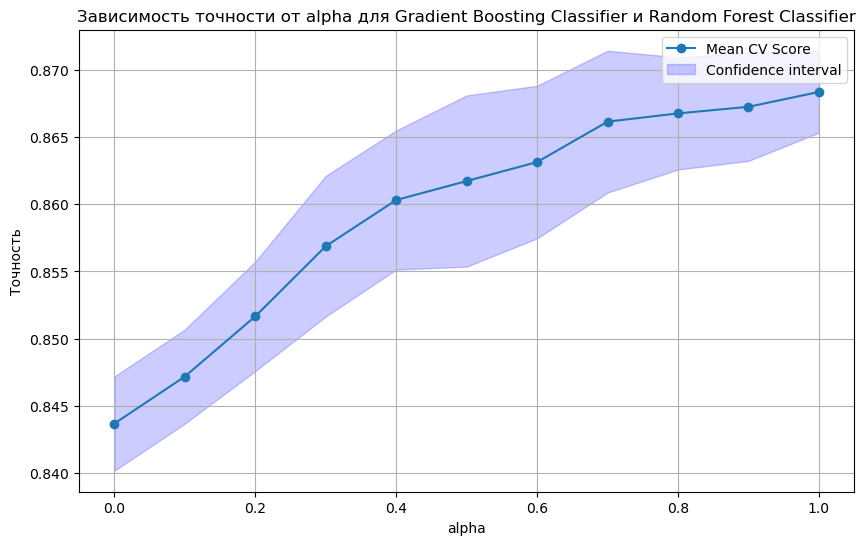


Лучшая alpha: 1.00, Точность: 0.8684


In [105]:
# Попробуем такую комбинацию - Gradient Boosting Classifier и Random Forest Classifier
# (обе модели показывают очень хорошие результаты по accuracy
# и используют 2 отличных друг от друга подхода (градиентный спуск и метод ансамблей)):

class MixedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf1, clf2, alpha=0.5):
        self.clf1 = clf1
        self.clf2 = clf2
        self.alpha = alpha

    def fit(self, X, y):
        self.clf1.fit(X, y)
        self.clf2.fit(X, y)
        return self

    def predict_proba(self, X):
        proba1 = self.clf1.predict_proba(X)
        proba2 = self.clf2.predict_proba(X)
        return self.alpha * proba1 + (1 - self.alpha) * proba2

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

clf1 = GradientBoostingClassifier(criterion="friedman_mse", max_features=None, n_estimators=288, random_state=42)
clf2 = RandomForestClassifier(criterion="entropy", max_features=None, n_estimators=20, random_state=42, n_jobs=-1)

alpha_values = np.linspace(0, 1, 11)
mean_accuracies = []
std_accuracies = []

for alpha in alpha_values:
    mixed_clf = MixedClassifier(clf1=clf1, clf2=clf2, alpha=alpha)
    scores = cross_val_score(mixed_clf, X_final, y, cv=5, scoring="accuracy", n_jobs=-1)
    mean_accuracies.append(np.mean(scores))
    std_accuracies.append(np.std(scores))
    print(f"alpha = {alpha:.2f}, Точность = {np.mean(scores):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mean_accuracies, marker='o', label='Mean CV Score')
plt.fill_between(
    alpha_values,
    np.array(mean_accuracies) - np.array(std_accuracies),
    np.array(mean_accuracies) + np.array(std_accuracies),
    color='blue', alpha=0.2, label='Confidence interval'
)
plt.title('Зависимость точности от alpha для Gradient Boosting Classifier и Random Forest Classifier')
plt.xlabel('alpha')
plt.ylabel('Точность')
plt.legend()
plt.grid()
plt.show()

best_alpha = alpha_values[np.argmax(mean_accuracies)]
best_accuracy = np.max(mean_accuracies)
print(f"\nЛучшая alpha: {best_alpha:.2f}, Точность: {best_accuracy:.4f}")

**Вывод для Gradient Boosting Classifier и Random Forest Classifier в сравнении с полиномиалом:**

Никаких качественных изменений мы, к сожалению, не получили - результат комбинации двух моделей дал ровно такой же результат по точности, как и в GradientBoosting-подходе. Вероятно, это связано с тем, что GradientBoosting является "преобладающей" моделью (ввиду своей и без того высокой точности), поэтому добавление Random Forest никак не влияет на результат. Ну а еще стоит упомянуть, что и Gradient Boosting, и Random Forest основаны на деревьях решений и все-таки имеют схожую природу, хоть и разнятся в подходах. Это, возможно, тоже повлияло на результат синергии.

alpha = 0.00, Точность = 0.8458
alpha = 0.10, Точность = 0.8499
alpha = 0.20, Точность = 0.8534
alpha = 0.30, Точность = 0.8576
alpha = 0.40, Точность = 0.8613
alpha = 0.50, Точность = 0.8642
alpha = 0.60, Точность = 0.8670
alpha = 0.70, Точность = 0.8685
alpha = 0.80, Точность = 0.8686
alpha = 0.90, Точность = 0.8688
alpha = 1.00, Точность = 0.8684


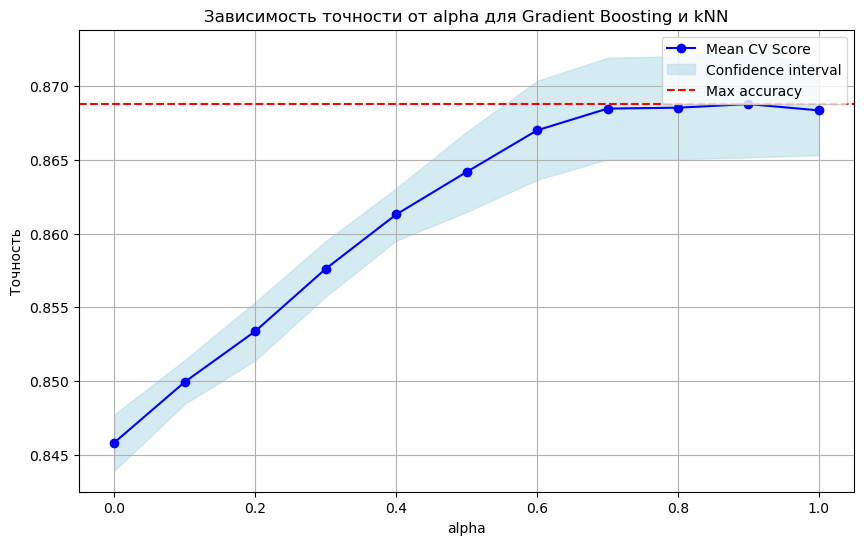


Лучшая alpha: 0.90, Точность: 0.8688


In [106]:
# А теперь посмотрим на синергию Gradient Boosting Classifier и kNN (принципиально раличные подходы):

class MixedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf1, clf2, alpha=0.5):
        self.clf1 = clf1
        self.clf2 = clf2
        self.alpha = alpha

    def fit(self, X, y):
        self.clf1.fit(X, y)
        self.clf2.fit(X, y)
        return self

    def predict_proba(self, X):
        proba1 = self.clf1.predict_proba(X)
        proba2 = self.clf2.predict_proba(X)
        return self.alpha * proba1 + (1 - self.alpha) * proba2

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

clf1 = GradientBoostingClassifier(criterion="friedman_mse", max_features=None, n_estimators=288, random_state=42)
clf2 = KNeighborsClassifier(metric="manhattan", n_neighbors=16)

alpha_values = np.linspace(0, 1, 11)
mean_accuracies = []
std_accuracies = []

for alpha in alpha_values:
    mixed_clf = MixedClassifier(clf1=clf1, clf2=clf2, alpha=alpha)
    scores = cross_val_score(mixed_clf, X_final, y, cv=5, scoring="accuracy", n_jobs=-1)
    mean_accuracies.append(np.mean(scores))
    std_accuracies.append(np.std(scores))
    print(f"alpha = {alpha:.2f}, Точность = {np.mean(scores):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mean_accuracies, marker='o', label='Mean CV Score', color='blue')
plt.fill_between(
    alpha_values,
    np.array(mean_accuracies) - np.array(std_accuracies),
    np.array(mean_accuracies) + np.array(std_accuracies),
    color='lightblue', alpha=0.5, label='Confidence interval'
)
plt.axhline(y=np.max(mean_accuracies), color='red', linestyle='--', label='Max accuracy')
plt.title('Зависимость точности от alpha для Gradient Boosting и kNN')
plt.xlabel('alpha')
plt.ylabel('Точность')
plt.legend()
plt.grid()
plt.show()

best_alpha = alpha_values[np.argmax(mean_accuracies)]
best_accuracy = np.max(mean_accuracies)
print(f"\nЛучшая alpha: {best_alpha:.2f}, Точность: {best_accuracy:.4f}")

**Вывод для Gradient Boosting Classifier и kNN в сравнении с полиномиалом:**

В данном случае мы уже видим рост в точности, пускай и не столь значительный (с 0.8684 до 0.8688). Но опять же, Gradient Boosting судя по всему слишком хорош сам по себе, поэтому и оптимальная alpha здесь высока (0.9), и изменения не очень значимые.

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

kNN: Точность = 0.8455, Стандартное отклонение = 0.0035

DecisionTree: Точность = 0.8499, Стандартное отклонение = 0.0031

RandomForest: Точность = 0.8440, Стандартное отклонение = 0.0072

GradientBoosting: Точность = 0.8684, Стандартное отклонение = 0.0030

SGDClassifier: Точность = 0.8426, Стандартное отклонение = 0.0063

Mixed (Gradient Boosting + kNN): Точность = 0.8642, Стандартное отклонение = 0.0027



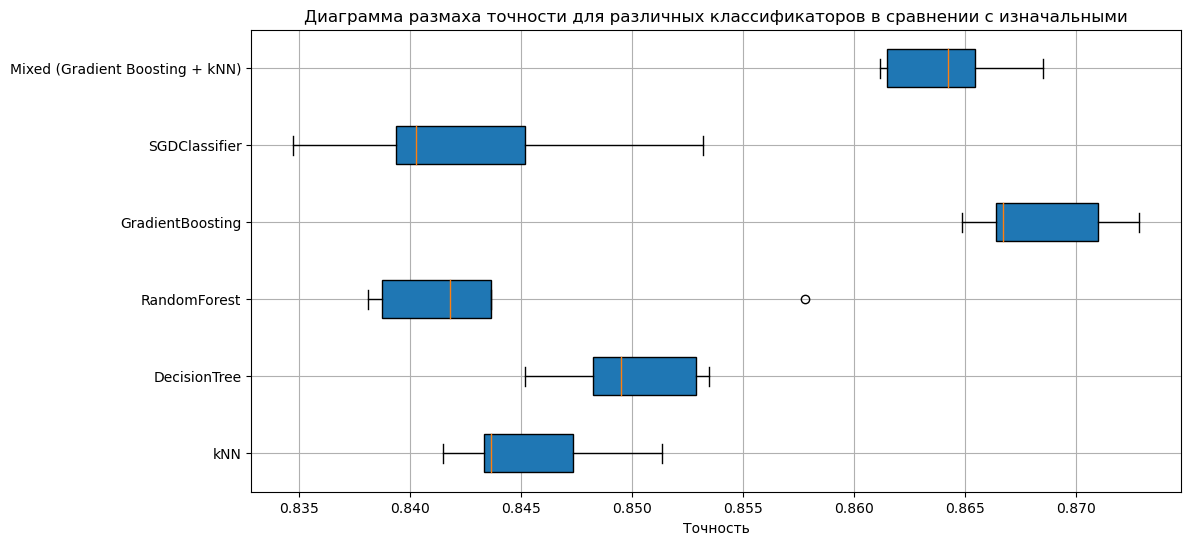

In [53]:
models = {
    "kNN": KNeighborsClassifier(metric='manhattan', n_neighbors=20),
    "DecisionTree": DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42),
    "RandomForest": RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=60, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(criterion='friedman_mse', max_features=None, n_estimators=288, random_state=42),
    "SGDClassifier": SGDClassifier(loss='log_loss', penalty='l1', random_state=42, max_iter=20000, tol=1e-3),
    "Mixed (Gradient Boosting + kNN)": MixedClassifier(
        clf1=GradientBoostingClassifier(criterion="friedman_mse", max_features=None, n_estimators=288, random_state=42),
        clf2=KNeighborsClassifier(metric="manhattan", n_neighbors=16),
        alpha=0.5
    )
}

model_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X_final, y, cv=5, scoring="accuracy", n_jobs=-1)
    model_scores[name] = scores
    print(f"{name}: Точность = {np.mean(scores):.4f}, Стандартное отклонение = {np.std(scores):.4f}")
    print()

plt.figure(figsize=(12, 6))
plt.boxplot(model_scores.values(), vert=False, patch_artist=True, labels=model_scores.keys())
plt.title("Диаграмма размаха точности для различных классификаторов в сравнении с изначальными")
plt.xlabel("Точность")
plt.grid()
plt.show()

**Итоговые выводы о наших классификаторах:**

***kNN:***

1. Гиперпараметры - n_neighbors (кол-во ближайших соседей) и metric (метрика расстояния);

2. Анализ - простая модель, чувствительная к масштабу данных, качество сильно зависит от числах соседей, сложность вычислений увеличивается по мере роста объема данных.

***Decision Tree:***

1. Гиперпараметры - max_depth (макс. глубина дерева) и criterion (критерий разбиения);

2. Анализ - простая и легко интерпретируемая модель, но склонная к переобучению при слишком большой глубине. Гиперпараметры существенно влияют на качество: правильно подобранный max_depth отвечает за сложность модели и её обобщающую способность.

***Random Forest:***

1. Гиперпараметры - n_estimators (кол-во деревьев в ансамбле), criterion (критерий разбиения), max_features (кол-во признаков для разбиения на каждом уровне);

2. Анализ - стабильная и мощная модель, устойчивая к переобучению благодаря ансамблевому подходу. Качество растёт с увеличением n_estimators, но в то же время замедляется обучение. Параметр max_features влияет на баланс между разнообразием деревьев и их качеством.

***SGDClassifier:***

1. Гиперпараметры - loss (функция потерь), penalty (тип регуляризации), alpha (коэффициент регуляризации);

2. Анализ - линейная модель, хорошо работающая с большими и разреженными данными. Чувствительна к выбору гиперпараметров, особенно alpha и penalty, которые контролируют степень регуляризации. Сложность модели низка, что делает её подходящей для больших наборов данных, однако качество ограничено линейностью.

***Mixed Classifier (Gradient Boosting + kNN):***

1. Гиперпараметры - alpha (вес моделей в линейной комбинации) + параметры для Gradient Boosting и kNN;

2. Анализ - смешивание моделей дало прирост точности за счёт комбинации разных подходов (деревья и метод ближайших соседей), пускай и не столь значительный (почему - объяснял выше). Оптимальный выбор alpha критически важен, иначе можно все легко испортить. Очень высокая вычислительнаая сложность из-за необходимости обучения сразу двух моделей.

**Спасибо за внимание, было приятно работать!**